<h1 id="tocheading">061119 Data Preparation for Notebooks in General</h1>
<div id="toc"></div>

Goal of this notebook is to preprocess 2016-2019 data into a nice csv for followon analysis.  

Main idea is to read in all the CSV's and do minimal prep here (just concat and super basic cleanup.  really anything that Rapids wont do well ...)

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-banner.png" width="800" height="500" align="middle"/>

### Import Libraries

In [1]:
# Code functions that are needed to run this lab
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import math

import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob
import os

import numpy as np

import sys
sys.path.append('../utils/') 
# from lc_utils import *


In [2]:
# !conda install jupyter
# !conda install pandasql
# !conda install seaborn
from pandasql import *
import pandasql as pq
import json
import dask
from dask import dataframe as dd
import time
import cudf as cuDF
from cudf.dataframe import DataFrame as RapidsDataFrame
# from dask.distributed import Client
# client = Client(processes=False)


In [3]:
%load_ext autoreload
%autoreload 2
import lc_utils as lc
import df_utils as dfu

lc.CLASS_ENVIRONMENT = 'acc'

In [4]:
#import df_utils as dfu
import lc2_utils as lc2


In [5]:
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [6]:
!conda list

# packages in environment at /gpfs/gpfs_gl4_16mb/s4s004/vanstee/anaconda3/envs/powerai-1.6.1:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_py-xgboost-mutex         1.0             gpu_0_493.ga6b967b    https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda
_tflow_select             2.1.0           gpu_723.g2e92f34    https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda
absl-py                   0.7.1                    py36_0  
arrow-cpp                 0.12.1          py36_513.gadf7d69    https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                    py36_0  
atomicwrites              1.3.0                    py36_1  
attrs                     19.1.0                   py36_1  
backcall                  0.1.0                    py36_0  
blas     

powerai-license           1.6.1              627.gc80b92e    https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda
powerai-release           1.6.1              488.g24b6af4    https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda
preshed                   1.0.1            py36he6710b0_0  
prometheus_client         0.7.1                      py_0  
prompt_toolkit            2.0.9                    py36_0  
protobuf                  3.7.1           py36_504.g85ad89d    https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda
psutil                    5.5.0            py36h7b6447c_0  
ptyprocess                0.6.0                    py36_0  
py                        1.8.0                    py36_0  
py-boost                  1.67.0           py36h04863e7_4  
py-opencv                 3.4.2           py36_640.g91b6d7a    https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda
py-xgboost-gpu            0.82          

### Load the Data
Here we load all the data into basic pandas dataframe and sample down .......


In [41]:
!pwd
# !ls ../rawdata

# This will load the dataset ...
loan_project = lc2.LCDF(mode='acc',num_files_to_load=10)


/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/dataprep_common
**__init__** : Loading Data.  Overriding __init__ from dfutils
**load_sample_data** : CLASS_ENVIRONMENT = acc
**load_sample_data** : Setting data location to /gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/rawdata/
**load_sample_data** : Found 13 files.  CSV files = ['/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2018Q1.csv.gz', '/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2017Q3.csv.gz', '/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2019Q1.csv.gz', '/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2016Q2.csv.gz', '/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2018Q4.csv.gz', '/gpfs/gpfs_gl4_16mb/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2018Q2.csv.gz', '/gpfs/gpfs_gl4_16mb/s4s004/

In [42]:
loan_project.df.count()

acc_now_delinq                                1279906
acc_open_past_24mths                          1279906
addr_state                                    1279906
all_util                                      1279621
annual_inc                                    1279906
annual_inc_joint                               125931
application_type                              1279906
avg_cur_bal                                   1279843
bc_open_to_buy                                1264104
bc_util                                       1263524
chargeoff_within_12_mths                      1279906
collection_recovery_fee                       1279906
collections_12_mths_ex_med                    1279906
debt_settlement_flag                          1279906
debt_settlement_flag_date                        2626
deferral_term                                    2728
delinq_2yrs                                   1279906
delinq_amnt                                   1279906
desc                        

In [9]:
loan_project.df.memory_usage(index=True).sum()
# 1.8 GB

421035136

In [58]:
#save_temp_df = loan_project.df.copy()
loan_project.df = save_temp_df.copy()


In [59]:
### Need to do this since Rapids cudf pukes otherwise
loan_project.df = loan_project.df.reset_index()

### Descriptive Statistics (1D)
Lets look at some 1D and 2D descriptive statistics for this dataset

In this dataset, we have all types of data.  Numerical, Categorical, Ranked data.  This small module will take you through what is typical done to quickly understand the data



In [60]:
# functions currently available
[x for x in dir(loan_project) if "__" not in x]

['clean_lendingclub_data',
 'create_fake_total_payment',
 'create_loan_default',
 'create_time_features',
 'detailed_overview',
 'df',
 'do_something',
 'drop_columns',
 'drop_rows',
 'drop_sparse_numeric_columns',
 'handle_employee_length',
 'handle_revol_util',
 'impute_columns',
 'load_sample_data',
 'one_hot_encode_keep_cols',
 'quick_overview_1d',
 'quick_overview_2d']

**Quick Question** : Can you find a negatively correlated variable to annual_inc in the chart above?  Can you think of a reason for this result ?

### Create Loan Default column.  This is the column we will predict later
The **loan_status** column contains the information of whether or not the loan is in default. 

This column has more than just a 'default or paid' status.  Since our goal is to build a simple default classifier , we need to make a new column based off the **loan_status** column.

Here we will look at all the categorical values in **loan_status**, and create a new column called **default** based off that one.


In [61]:
# function to create loan status .... 
loan_project.create_loan_default()
loan_project.create_fake_total_payment()


**create_loan_default** : Unique values in loan_status
Current               1042736
Fully Paid             147551
Charged Off             36572
Late (31-120 days)      19285
Issued                  18988
In Grace Period         10238
Late (16-30 days)        4491
Default                    45
Name: loan_status, dtype: int64
**create_loan_default** : Dropping other values that are highly correlated with loan_status
**create_loan_default** : Dropping loan_status,total_rec_prncp,total_pymnt,total_pymnt_inv
**create_loan_default** : Unique values in default
0    1219535
1      60393
Name: default, dtype: int64


0

In [62]:
loan_project.df.head()

,index,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rec_int,total_rec_late_fee,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,default
0,0,0.0,8.0,PA,52.0,53700.0,NaN,Individual,5713.0,20806.0,7.5,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,28.56,NaN,Nov-2001,10+ years,Facility manager,779.0,775.0,2500.0,2500.0,A,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,130966408,85.0,w,3.0,4.0,3.0,76.87,6.71%,Mar-2018,Apr-2018,779.0,775.0,0.0,NaN,2500.0,1518.0,NaN,147.0,196.0,4.0,1.0,3.0,NaN,NaN,NaN,1.0,52.0,NaN,1.0,NaN,Apr-2018,0.0,2.0,6.0,4.0,8.0,20.0,10.0,15.0,6.0,20.0,0.0,0.0,0.0,5.0,20.0,4.0,8.0,4.0,6.0,1.0,2.0,NaN,2500.0,2500.0,NaN,100.0,0.0,1.0,0.0,0.0,other,n,0.0,8289.0,NaN,15.6%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A3,0.0,36 months,Other,0.0,114256.0,225791.0,38.0,58875.0,50586.0,22500.0,11.0,59491.0,0.0,0.0,53100.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,166xx,0
1,1,0.0,2.0,OR,61.0,40000.0,110000.0,Joint App,51837.0,15700.0,51.8,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,27.78,12.15,Mar-2003,6 years,Dental assistance/administration,729.0,725.0,25000.0,25000.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,130846589,NaN,w,0.0,1.0,0.0,563.85,12.61%,Mar-2018,Mar-2018,729.0,725.0,0.0,NaN,25000.0,7471.0,NaN,125.0,180.0,19.0,19.0,2.0,NaN,NaN,NaN,57.0,24.0,NaN,11.0,NaN,Apr-2018,0.0,3.0,4.0,5.0,8.0,3.0,7.0,11.0,5.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,25000.0,25000.0,NaN,100.0,40.0,1.0,0.0,0.0,debt_consolidation,n,0.0,107401.0,35634.0,60.6%,0.0,0.0,Mar-2003,694.0,690.0,0.0,2.0,NaN,11.0,10.0,0.0,56.0,NaN,NaN,NaN,NaN,NaN,C1,0.0,60 months,Debt consolidation,0.0,414695.0,502520.0,16.0,107401.0,0.0,32600.0,2.0,0.0,0.0,0.0,126600.0,https://lendingclub.com

### Minor stuff

In [63]:
loan_project.df = loan_project.df.drop(['desc'],axis=1)

In [64]:
# loan_project.one_hot_encode_keep_cols(drop_original_cols=False)

In [65]:
display(loan_project.df.head())


,index,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rec_int,total_rec_late_fee,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,default
0,0,0.0,8.0,PA,52.0,53700.0,NaN,Individual,5713.0,20806.0,7.5,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,Cash,28.56,NaN,Nov-2001,10+ years,Facility manager,779.0,775.0,2500.0,2500.0,A,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,130966408,85.0,w,3.0,4.0,3.0,76.87,6.71%,Mar-2018,Apr-2018,779.0,775.0,0.0,NaN,2500.0,1518.0,NaN,147.0,196.0,4.0,1.0,3.0,NaN,NaN,NaN,1.0,52.0,NaN,1.0,NaN,Apr-2018,0.0,2.0,6.0,4.0,8.0,20.0,10.0,15.0,6.0,20.0,0.0,0.0,0.0,5.0,20.0,4.0,8.0,4.0,6.0,1.0,2.0,NaN,2500.0,2500.0,NaN,100.0,0.0,1.0,0.0,0.0,other,n,0.0,8289.0,NaN,15.6%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A3,0.0,36 months,Other,0.0,114256.0,225791.0,38.0,58875.0,50586.0,22500.0,11.0,59491.0,0.0,0.0,53100.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,166xx,0
1,1,0.0,2.0,OR,61.0,40000.0,110000.0,Joint App,51837.0,15700.0,51.8,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,Cash,27.78,12.15,Mar-2003,6 years,Dental assistance/administration,729.0,725.0,25000.0,25000.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,130846589,NaN,w,0.0,1.0,0.0,563.85,12.61%,Mar-2018,Mar-2018,729.0,725.0,0.0,NaN,25000.0,7471.0,NaN,125.0,180.0,19.0,19.0,2.0,NaN,NaN,NaN,57.0,24.0,NaN,11.0,NaN,Apr-2018,0.0,3.0,4.0,5.0,8.0,3.0,7.0,11.0,5.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,25000.0,25000.0,NaN,100.0,40.0,1.0,0.0,0.0,debt_consolidation,n,0.0,107401.0,35634.0,60.6%,0.0,0.0,Mar-2003,694.0,690.0,0.0,2.0,NaN,11.0,10.0,0.0,56.0,NaN,NaN,NaN,NaN,NaN,C1,0.0,60 months,Debt consolidation,0.0,414695.0,502520.0,16.0,107401.0,0.0,32600.0,2.0,0.0,0.0,0.0,126600.0,https://lendingclub.com/browse/loanD

### Descriptive Statistics (1 and 2D)
Since we have over 100 numerical variables, creating a 2D correlation plot may be time consuming and difficult to interpret.  Lets look at correlations on a smaller scale for now....


In [66]:
# This function provide the number of rows/cols
# Information on the types of data
# and a report of descriptive statistics

loan_project.quick_overview_1d()

**df_utils:quick_overview_1d** : There are 1279928 observations in the dataset.
**df_utils:quick_overview_1d** : There are 148 variables in the dataset.
**df_utils:quick_overview_1d** : 


**df_utils:quick_overview_1d** : 
****************** Histogram of data types  *****************************

**df_utils:quick_overview_1d** : use df.dtypes ...
float64    108
object      38
int64        2
Name: dtype, dtype: int64
**df_utils:quick_overview_1d** : 


**df_utils:quick_overview_1d** : 
****************** Generating Cardinality Report (all types) *****************************

**df_utils:quick_overview_1d** : 
****************** Generating NaNs Report *****************************

**df_utils:quick_overview_1d** : 
******************Generating Descriptive Statistics (numerical columns only) *****************************

 running df.describe() ....


,dtype,cardinality,nan_count,pct_missing,count,mean,std,min,25%,50%,75%,max
next_pymnt_d,object,9,184145,14.387137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_pymnt_d,object,42,27189,2.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_flag,object,2,22,0.001719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_loan_status,object,5,1277200,99.786863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_reason,object,9,1277200,99.786863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_start_date,object,21,1277200,99.786863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_status,object,3,1277200,99.786863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_type,object,1,1277200,99.786863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,object,5,22,0.001719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,object,1279928,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Grab only a subset of columns
cols = ["loan_amnt","annual_inc","dti","fico_range_high","open_acc",'funded_amnt', 'total_acc','grade','default','issue_d','earliest_cr_line','addr_state']

#estreamDF_cu = DataFrame.from_pandas(pd.DataFrame(estreamDF_o))

**df_utils:quick_overview_2d** : There are 1279928 observations in the dataset.
**df_utils:quick_overview_2d** : There are 148 variables in the dataset.


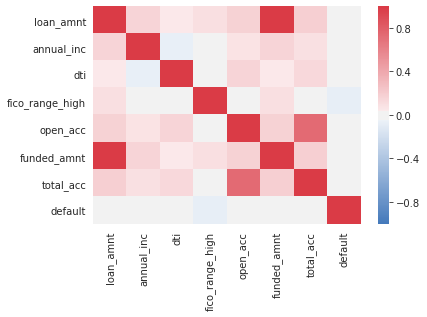

In [49]:
loan_project.quick_overview_2d(cols)

In [ ]:
# This will take a minute or so ...
# bob_heatmap_lc(my_analysis.test_df,sortColumn='loan_amnt',add_corr=1)

In [68]:
# Required for GPU DF
loan_project.df = loan_project.df[cols].dropna()
loan_project.df = loan_project.df.reset_index()
display(loan_project.df[cols].iloc[107864:107870,:])


,loan_amnt,annual_inc,dti,fico_range_high,open_acc,funded_amnt,total_acc,grade,default,issue_d,earliest_cr_line,addr_state
107864,12000.0,64000.0,19.07,724.0,3.0,12000.0,20.0,B,0,Sep-2017,Oct-1999,MD
107865,15000.0,120000.0,7.06,699.0,12.0,15000.0,16.0,B,0,Sep-2017,Aug-2011,CA
107866,29000.0,88000.0,21.55,729.0,33.0,29000.0,50.0,C,0,Sep-2017,Nov-2004,AZ
107867,10000.0,35000.0,26.08,714.0,13.0,10000.0,22.0,B,0,Sep-2017,Jan-2011,NY
107868,14000.0,63000.0,33.14,684.0,9.0,14000.0,36.0,B,0,Sep-2017,Sep-2003,CA
107869,6000.0,42000.0,18.80,704.0,12.0,6000.0,17.0,B,0,Sep-2017,Aug-1999,HI


In [69]:
loan_project.df[cols].dtypes
loan_project.df['issue_d'] = loan_project.df['issue_d'].map(lambda x: datetime.strptime(str(x), "%b-%Y"))
loan_project.df['earliest_cr_line'] = loan_project.df['earliest_cr_line'].map(lambda x: datetime.strptime(str(x), '%b-%Y'))

# X['time_history'] = X['issue_d'] - X['earliest_cr_line']
# X['time_history'] = X['time_history'].astype('timedelta64[D]').astype(int)
        
loan_project.df[cols].dtypes  

loan_amnt                  float64
annual_inc                 float64
dti                        float64
fico_range_high            float64
open_acc                   float64
funded_amnt                float64
total_acc                  float64
grade                       object
default                      int64
issue_d             datetime64[ns]
earliest_cr_line    datetime64[ns]
addr_state                  object
dtype: object

In [70]:
loan_project.df[cols].to_parquet('loan_project_df.parquet.gzip', compression='gzip')  
# >>> pd.read_parquet('df.parquet.gzip')

### Data Preparation - Handle Null Values aka NaNs ...

One part of the data science process thats especially time consuming is working with unclean data.  This lending club data set is a great example of that.  If you look at the dataframe shown above, you will see a number of columns with the indicator **NaN** .  This means 'not a number' and needs to be dealt with prior to any machine learning steps.  You have many options here.  Some options are listed below...

* Fill with a value -> impute mean/median/min/max/other
* drop rows with NaNs
* drop columns with large number of NaNs 
* use data in other columns to derive

All these methods are possible, but its up to the data scientist / domain expert to figure out the best approach.  There is definitely some grey area involved in whats the best approach.

First, lets understand which columns have NaNs...

In [ ]:
# For every column, count the number of NaNs .... 
# code hint : uses df.isna().sum()

loan_mldf.df_meta['nan_count']

In [ ]:
print(loan_mldf.df.dtypes)
print("####################")
loan_mldf.df.infer_objects().dtypes
a = loan_mldf.df.isna().sum()

In [ ]:
adf = pd.DataFrame(a,columns=["nan"])
bdf = pd.DataFrame(loan_mldf.df.dtypes,columns=["types"])

cdf = adf.join(bdf,how="outer")
cdf

In [ ]:
loan_mldf.quick_overview_1d()


As you can see, we have some work to do to clean up the NaN values.  Beyond NaN values, we also have to transform columns if they aren't formatted correctly, or maybe we want to transform a column based on custom requirements.  

```
Example : column=employee_length , values=[1,2,3,4,5,6,7,8,9,10+] formatted as a string
          transform into 
          column=employee_length, [0_3yrs,4_6yrs,gt_6yrs] (categorical:strings)
```
          
Luckily, we took care to process and clean this data below using a few functions.  In practice, **this is where data scientists spend a large portion of their time** as this requires detailed domain knowledge to clean the data.  We have made a fair number of assumptions about how to process the data which we won't go into due to time contraints for the lab.

In [ ]:
# The following cleaning of the data makes use of the steps shown below.....

#loan_df1 = drop_sparse_numeric_columns(loan_df)
#loan_df2 = drop_columns(loan_df1)
#loan_df3 = impute_columns(loan_df2)
#loan_df4 = handle_employee_length(loan_df3)
#loan_df5 = handle_revol_util(loan_df4)
#loan_df6 = drop_rows(loan_df5)

loan_df = clean_lendingclub_data(loan_df)


In [ ]:
# Final Sanity check ....
# If we did our job right, there should not be any NaN's left.  
# Use this convenience function to check

# code hint df.isna().sum()

columns_with_nans(loan_df)